In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import numpy as np
import matplotlib.pyplot as plt
from pyfrechet.metric_spaces import MetricData, RiemannianManifold, CorrFrobenius
from geomstats.geometry.hypersphere import Hypersphere
import pandas as pd
from pyfrechet.metric_spaces.correlation.nearcorr import nearcorr
from tqdm import tqdm
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import norm

INFO: Using numpy backend
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/fdasrsf/umap_metric.py:22: NumbaDeprecationWarning:The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/fdasrsf/umap_metric.py:54: NumbaDeprecationWarning:The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/pyt

# R with multiplicative noise

In [3]:
def m(x, theta, mu):
    return theta * x + (1-theta)*mu

def sim(N, theta, sig, mu):
    x = np.zeros(N) + mu
    for i in range(1,N):
        x[i] = m(x[i-1], theta, mu) + sig*np.random.randn()
    return x

def sim_mul(N, theta, sig, mu):
    x = np.zeros(N) + mu
    for i in range(1,N):
        x[i] = (1 + sig*np.random.randn()) * m(x[i-1], theta, mu)
    return x

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:16<00:00, 59.09it/s]

% rejects under H1 1.0
% rejects under H0 0.048


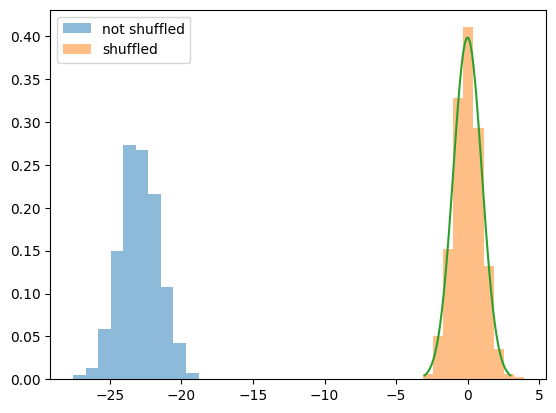

In [4]:
res = np.zeros((1000, 4))
theta = 0.65
N = 1_000
B = 1_000

def bootstrap_mu_sig(x, B):
    # DIRECT ESTIMATION - check this a bit more
    #
    # D_XY_XZ = np.zeros((2, B))
    # for b in range(B):
    #     idx = np.random.randint(N, size=3)
    #     D_XY_XZ[0, b] = np.abs(x[idx[0]] - x[idx[1]])
    #     D_XY_XZ[1, b] = np.abs(x[idx[0]] - x[idx[2]])

    # cov = np.cov(D_XY_XZ)
    # sig_hat = np.sqrt(cov[0,0] + 2*cov[0,1]) / np.sqrt(B)
    # mu_hat = D_XY_XZ[0,:].mean()

    # BOOTSTRAP VERSION
    # 
    bootstrap = np.zeros(B)
    for b in range(B):
        permed = np.random.permutation(x)
        bootstrap[b] = np.mean(np.abs(np.diff(permed)))
    
    sig_hat = np.sqrt(bootstrap.var())
    mu_hat = bootstrap.mean()
    
    return mu_hat, sig_hat

for i in tqdm(range(res.shape[0])):
    x = sim_mul(N, theta, 0.13, mu)

    res[i,0] = np.mean(np.abs(np.diff(x)))

    permed = np.random.permutation(x)
    res[i,1] =  np.mean(np.abs(np.diff(permed)))

    mu_hat, sig_hat = bootstrap_mu_sig(x, B)
    res[i, 2] = mu_hat
    res[i, 3] = sig_hat

plt.hist((res[:, 0] - res[:, 2]) / res[:, 3], label='not shuffled', alpha=0.5, density=True)
plt.hist((res[:, 1] - res[:, 2]) / res[:, 3], label='shuffled', alpha=0.5, density=True)

_x = np.linspace(-3, 3)
plt.plot(_x, norm.pdf(_x))

print("% rejects under H1", (np.abs((res[:, 0] - res[:, 2]) / res[:, 3]) > norm.ppf(0.975)).mean())
print("% rejects under H0", (np.abs((res[:, 1] - res[:, 2]) / res[:, 3]) > norm.ppf(0.975)).mean())

plt.legend()


# Wasserstein